In [ ]:
# google drive 연동
# 모두 '예' 선택
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/nlp_basic/

/content/drive/MyDrive/nlp_basic


# CBOW 아키텍처

<img src="https://drive.google.com/uc?id=1RqXPG5vwS85L-Ii1cxfiSEjWXdQkAdZ-" width='600'>



<img src="https://drive.google.com/uc?id=1s1R9XJwr319T0YV_NHMlGFZOFmnANrF3" width='1000'>




In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        # windows size 1임을 가정하고 in_layer 경로를 2개 만듦
        self.in_layer1 = MatMul(W_in)
        self.in_layer2 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer1, self.in_layer2, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer1.forward(contexts[:, 0]) # 첫번째 맥락, batch, contexts, vocab_size
        h1 = self.in_layer2.forward(contexts[:, 1]) # 두번째 맥락
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5 # 2개 단어가 Loss에 대해 관여하였으므로 나누기 2
        self.in_layer1.backward(da)
        self.in_layer2.backward(da)
        return None


# 학습 데이터 수집

word2vec 학습을 위해 원하는 주제의 위키피디아 데이터를 가져옵니다.

In [ ]:
# 필요한 라이브러리 설치
!pip install wikipedia-api
!pip install konlpy

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15383 sha256=cc95b9f330f28b92c7d4627be767bf568fc8975c416caaa7bba46f09b8c1a43a
  Stored in directory: /root/.cache/pip/wheels/0b/0f/39/e8214ec038ccd5aeb8c82b957289f2f3ab2251febeae5c2860
Successfully built wikipedia-api
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 20.8 MB/s eta 0:00:00


In [ ]:
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia(user_agent='test-agent', language='ko')

In [ ]:
# 원하는 주제를 선정하세요(위키피디아에 있는 주제)
wiki_data = wiki_wiki.page('박지성')
wiki_data_summary = "제목: " + wiki_data.title + "\n요약: " + wiki_data.summary
print(wiki_data_summary)

print("문서 길이: " + str(len(wiki_data.text)))
print(wiki_data.text)

제목: 박지성
요약: 박지성(1981년 2월 25일~)은 대한민국의 은퇴한 프로 축구 선수로 현역 시절 포지션은 윙어, 미드필더이다. 현재 전북 현대 모터스의 클럽 고문으로 재직 중이다. 서울에서 태어난 그는 선수로 활동하는 동안 트로피 19개를 획득했다. UEFA 챔피언스리그에서 우승한 최초의 아시아 축구 선수이고 챔피언스리그 결승전에 진출한 2명의 아시아 축구 선수(박지성, 손흥민) 중 한 명이자 FIFA 클럽 월드컵에서 우승을 한 최초의 아시아인 선수이다. 그는 뛰어난 체력과 훈련, 프로 의식으로 유명했으며, 그의 지구력으로 인해 "폐 3개 가진 박(Three-Lungs Park)"이라는 별명을 얻었다.
어린 시절부터 축구를 시작한 그는 명지대학교 축구부에서 활동했으며, 2000년에 일본으로 건너가 교토 퍼플 상가에서 활동하며 프로 선수 경력을 시작했다. 그 후 2003년에 대한민국 국가대표팀 감독을 맡았던 거스 히딩크가 네덜란드로 돌아와 감독을 맡은 팀인 네덜란드의 PSV 에인트호번에 입단하여 유럽 리그로 진출을 했다. PSV가 2004-05년 UEFA 챔피언스리그 준결승에 진출한 후 맨체스터 유나이티드 FC의 감독 알렉스 퍼거슨에게 인정을 받아 2005년 7월에 맨체스터 유나이티드와 계약을 맺었다. 그는 프리미어리그에서 4번 우승했으며, 2007-08년 UEFA 챔피언스리그, 2008년 FIFA 클럽 월드컵에서 우승하는 데에 기여하였다. 이후 주전 출전 횟수가 감소하자 2012년 7월 퀸스 파크 레인저스 FC로 이적했다. 그러나 이적 시즌에 자신의 부상과 소속팀의 강등으로 인해 2013-14 시즌에 임대 형식으로 PSV 에인트호번에 합류했다. 이후 2014년에 PSV에서의 활동을 마지막으로 현역에서 은퇴했다.
대한민국 국가대표팀의 일원으로도 활동하여 A매치 100경기에 출전하여 13골을 넣었다. 그는 2002년 FIFA 월드컵에서 4위를 한 대한민국팀의 일원이었으며, 2006년 FIFA 월드컵과 2010년 FIFA 월드컵에서도 대한민국 국가대표로 참가

In [ ]:
# 효율적인 학습을 위해 조사, 어미, 구두점 제거

from konlpy.tag import Okt

# Okt 객체 생성
okt = Okt()

okt_pos = okt.pos(wiki_data.text, norm=True, stem=True)

word_list = []
for word in okt_pos:
    if word[1] not in ['Josa', 'Eomi', 'Punctuation']:
        word_list.append(word[0])

preprocessed_data = ' '.join(word_list)

In [ ]:
preprocessed_data

'박지성 1981년 2월 25일 은 대한민국 은퇴 프로 축구 선수 현역 시절 포지션 윙어 미드필더 현재 전북 현대 모터스 클럽 고문 재직 중이 서울 태어나다 그 선수 활동 하다 동안 트로피 19 개 획득 하다 UEFA 챔피언스리그 우승하다 최초 아시아 축구 선수 챔피언스리그 결승전 진출 2 명의 아시아 축구 선수 박지성 손흥민 중 하다 명 이자 FIFA 클럽 월드컵 우승 하다 최초 아시아 선수 그 뛰어나다 체력 훈련 프로 의식 유명하다 그 지구력 인하다 폐 3 개 가지다 박 Three Lungs Park 별명 얻다 \n 어리다 시절 축구 시작 그 명지대 학교 축구 부 활동 하다 2000년 에 일본 건너가다 교토 퍼플 상가 활동 하다 프로 선수 경력 시작 하다 그 후 2003년 에 대한민국 국가대표팀 감독 맡다 거스 히딩크 네덜란드 돌아오다 감독 맡다 팀 네덜란드 PSV 에인트호번 입단 하다 유럽 리그 진출 하다 PSV 가다 2004-05년 UEFA 챔피언스리그 준결승 진출 후 맨체스터 유나이티드 FC 의 감독 알렉스 퍼거슨 인정 받다 2005년 7월 에 맨체스터 유나이티드 계약 맺다 그 프리미어리그 4 번 우승하다 2007-08년 UEFA 챔피언스리그 2008년 FIFA 클럽 월드컵 우승하다 데 기여 하다 이후 주전 출전 횟수 감소 하다 2012년 7월 퀸스 파크 레인저스 FC 로 이적 하다 그러나 이적 시즌 자신 부상 소 속 팀 강등 인하다 2013-14 시즌 임대 형식 PSV 에인트호번 합류 하다 이후 2014년 에 PSV 활동 마지막 현역 은퇴 하다 \n 대한민국 국가대표팀 일원 활동 하다 A 매치 100 경기 출전 하다 13 골 넣다 그 2002년 FIFA 월드컵 4 위 하다 대한민국 팀 일원 이다 2006년 FIFA 월드컵 2010년 FIFA 월드컵 대한민국 국가대표 참가 하다 그 월드컵 맨 오브 더 매치 팬 투표 3회 선정 되어다 손흥민 안정환 함께 3 골 14 경기 로 한국 선수 월드컵 최 득점 자 현재 국제 축구 평의회 자문 위원 전북 현대 모터

# 학습시작

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
| 에폭 28 |  반복 341 / 570 | 시간 20[s] | 손실 3.61
| 에폭 28 |  반복 361 / 570 | 시간 20[s] | 손실 3.46
| 에폭 28 |  반복 381 / 570 | 시간 20[s] | 손실 3.29
| 에폭 28 |  반복 401 / 570 | 시간 20[s] | 손실 3.61
| 에폭 28 |  반복 421 / 570 | 시간 20[s] | 손실 3.38
| 에폭 28 |  반복 441 / 570 | 시간 20[s] | 손실 3.75
| 에폭 28 |  반복 461 / 570 | 시간 20[s] | 손실 3.48
| 에폭 28 |  반복 481 / 570 | 시간 20[s] | 손실 3.65
| 에폭 28 |  반복 501 / 570 | 시간 20[s] | 손실 3.60
| 에폭 28 |  반복 521 / 570 | 시간 20[s] | 손실 3.55
| 에폭 28 |  반복 541 / 570 | 시간 20[s] | 손실 3.64
| 에폭 28 |  반복 561 / 570 | 시간 20[s] | 손실 3.44
| 에폭 29 |  반복 1 / 570 | 시간 20[s] | 손실 3.56
| 에폭 29 |  반복 21 / 570 | 시간 20[s] | 손실 2.97
| 에폭 29 |  반복 41 / 570 | 시간 20[s] | 손실 3.03
| 에폭 29 |  반복 61 / 570 | 시간 20[s] | 손실 3.21
| 에폭 29 |  반복 81 / 570 | 시간 20[s] | 손실 3.06
| 에폭 29 |  반복 101 / 570 | 시간 20[s] | 손실 3.14
| 에폭 29 |  반복 121 / 570 | 시간 20[s] | 손실 3.16
| 에폭 29 |  반복 141 / 570 | 시간 20[s] | 손실 3.22
| 에폭 29 |  반복 161 / 570 | 시간 20[s] | 손실 3.31
| 에폭 29 |  반복 181 / 570 |

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


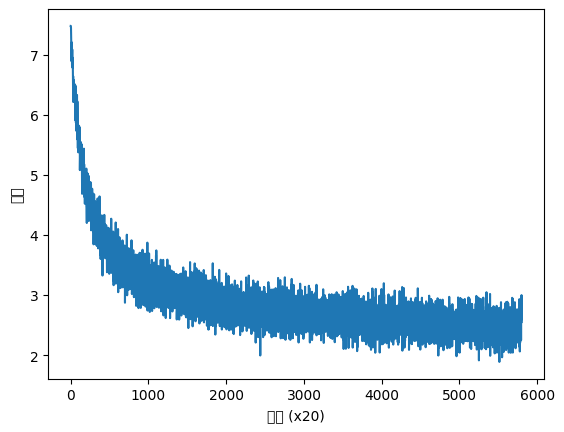

In [ ]:
# coding: utf-8
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 10
max_epoch = 200
lr=0.01

text = preprocessed_data

# 조사 등이 제거 된 데이터를 기준으로
# 공백 기준으로 분할하여 Vocabulary를 생성함
# corpus: 텍스트 내 모든 단어 ID 시퀀스
# word_to_id: 단어를 ID로 변환하는 딕셔너리, 예시: {'박지성': 1, '히딩크': 2}
# id_to_word: ID를 단어로 변환하는 딕셔너리, 예시: {1: '박지성', 2: '히딩크'}
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size) # 중간 단어와 맥락 단어 데이터 생성
target = convert_one_hot(target, vocab_size) # 타겟 데이터를 one-hot encoding으로 변환, 박지성 = [1, 0, 0, 0, ...]
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam(lr=lr)
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [ ]:
# 학습이 완료된 후 벡터의 모습을 확인합니다.
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

박지성 [-0.37066054 -0.78443533  1.3291068  -1.2313032  -0.12379938]
1981년 [  3.9919958   -0.33113763  -0.89150375  -8.841565   -23.042694  ]
2월 [  7.3527055 -13.041211   -0.8654868  -1.164295   -5.780808 ]
25일 [ -6.7669396 -16.354458   -0.6298817 -15.035025    4.4232187]
은 [ 1.371627   -2.6870177   0.8450019  -2.1488266  -0.97079325]
대한민국 [-2.0523088 -1.6140627  0.8785475 -1.3585522  1.0739005]
은퇴 [-3.8508646 -1.8637052  0.4500339 -1.2647607  2.256299 ]
프로 [-0.8647114  -1.1700394   0.22936389  0.121357    1.3352773 ]
축구 [-5.8195844  -4.0564013  -0.38989902  1.1483287   0.28139195]
선수 [-1.6704557  -3.1306775  -0.59419596 -1.6243994   0.672186  ]
현역 [-4.373963   -0.41858652  2.9590683  -1.4531109   1.46636   ]
시절 [-0.41243953 -1.8513634  -0.7091324  -2.933804    1.6183168 ]
포지션 [ 2.5065432   3.0102465   0.09766158 -4.359656   -1.4364902 ]
윙어 [ 0.62609035  1.7592517  -1.7625686  -2.172261   -0.4572009 ]
미드필더 [ 1.7586935   1.1901249  -0.28513795 -0.8520651   1.4854459 ]
현재 [ 1.2472965 -0.511

# 평가

학습이 잘 됐는지 평가하기 위해, 유사한 단어들을 찾아보세요

In [ ]:
from common.util import most_similar

# 가장 비슷한(most similar) 단어 뽑기
querys = ['박지성', '히딩크', '맨유']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=10)


[query] 박지성
 그리고: 0.9822012186050415
 주다: 0.9673401117324829
 2000~2003: 0.9627329707145691
 함께: 0.9591667056083679
 2002년: 0.950745165348053
 확정: 0.9405885934829712
 위키인용집: 0.9201222658157349
 에레디비시: 0.9195919632911682
 방송: 0.9044495224952698
 맨체스터: 0.9038324952125549

[query] 히딩크
 공격수: 0.9803759455680847
 공: 0.9728412628173828
 중학교: 0.9316425919532776
 격인: 0.9299907684326172
 수립: 0.9211708903312683
 를: 0.9052500128746033
 통합: 0.8994854688644409
 –: 0.8946914672851562
 인종차별: 0.8934947848320007
 추억: 0.8897465467453003

[query] 맨유
 라이언: 0.97422856092453
 유나이티드: 0.9528160095214844
 얻다: 0.9362369775772095
 포지션: 0.9235888123512268
 라운드: 0.9114948511123657
 205: 0.9075900912284851
 에는: 0.9068073034286499
 온: 0.8984624147415161
 강전: 0.8889843225479126
 리거: 0.8693252801895142


# 추가 문제

1. windows size를 1이 아니라 2로 늘려보세요.